# One-Dimensional Climate Models: Brown Dwarfs w/ Disequilibrium Chemistry with Constant Kzz (~Elf Owl)

In this tutorial you will learn how to run 1d climate models with the effects of disequilibrium chemistry as was done for the Elf-OWL Grid [Mukherjee et al. 2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240200756M/abstract) (note this should also be cited if using this code/tutorial). 

What you should already be familiar with: 

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)
- [how to run a basic 1d brown dwarf tutorial](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html)


What should have already downloaded: 

1. [Download](https://zenodo.org/record/5590989#.Yzy2YOzMI8a) 1460 PT, 196 wno Correlated-K Tables from Roxana Lupu to be used by the climate code for opacity 
2. [Download the .npy](https://doi.org/10.5281/zenodo.10895826) and place them in picaso_refdata folder/climate_INPUTS/ktable_by_molecule/

> **_NOTE:_**  Tip for getting data from zenodo: pip install zenodo_get then it you can simply retrieve a zenodo posting via the command zenodo_get 10.5281/zenodo.10895826 


### First, check that you have downloaded and placed the correlated-k files in the correct folder

In [1]:
import os;import glob
[i.split('/')[-1].split("_")[0] for i in glob.glob(
    os.path.join(os.environ['picaso_refdata'],'climate_INPUTS','ktable_by_molecule','*npy')
)]
#should see a list of molecules (ie. ['H3+', 'FeH', 'C2H2'....])

['H3+',
 'FeH',
 'C2H2',
 'LiH',
 'H2S',
 'C2H4',
 'VO',
 'CO',
 'OCS',
 'MgH',
 'SO2',
 'LiCl',
 'CaH',
 'CO2',
 'Rb',
 'Na',
 'CH4',
 'TiO',
 'CrH',
 'HCN',
 'Li',
 'O2',
 'O3',
 'H2O',
 'Fe',
 'Cs',
 'H2',
 'SiO',
 'PH3',
 'NH3',
 'LiF',
 'K',
 'C2H6',
 'N2',
 'TiH']

In [2]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from astropy import constants as const
from astropy import units as u
import sys
import pandas as pd

## Setting up Initial Run (highlighting main differences for disequilibrium)

In [ ]:
gases_fly = ['CO','CH4','H2O','NH3','CO2','N2','HCN','H2','He','PH3','C2H2','Na','K','TiO','VO','FeH']

opacity_ck = jdi.opannection(method='resortrebin',preload_gases=gases_fly) # grab your opacities

In [4]:
elf = jdi.xr.load_dataset('spectra_logzz_9.0_teff_950.0_grav_56.0_mh_0.7_co_1.0.nc')
elf

<xarray.Dataset>
Dimensions:      (wavelength: 193132, pressure: 91)
Coordinates:
  * wavelength   (wavelength) float64 15.0 15.0 15.0 15.0 ... 0.6 0.6 0.6 0.6
  * pressure     (pressure) float64 0.0001778 0.000205 0.0002363 ... 55.23 63.66
Data variables: (12/40)
    flux         (wavelength) float64 1.716e+09 1.722e+09 ... 3.777e+05
    temperature  (pressure) float64 309.6 310.7 312.2 ... 3.227e+03 3.306e+03
    e-           (pressure) float64 4.5e-38 4.5e-38 ... 9.713e-07 1.125e-06
    H2           (pressure) float64 0.8272 0.8272 0.8271 ... 0.7973 0.7927
    H            (pressure) float64 4.298e-33 5.412e-33 ... 0.03637 0.04143
    H+           (pressure) float64 4.5e-38 4.5e-38 ... 7.752e-17 2.247e-16
    ...           ...
    OCS          (pressure) float64 1.032e-25 1.018e-25 ... 9.107e-09 8.842e-09
    Li           (pressure) float64 4.5e-38 4.5e-38 ... 1.394e-08 1.379e-08
    LiOH         (pressure) float64 4.5e-38 4.5e-38 ... 6.835e-10 6.427e-10
    LiH          (pressure) float64 4.5e-38 4.5e-38 ... 2.646e-09 2.753e-09
    LiCl         (pressure) float64 4.5e-38 4.5e-38 ... 9.78e-12 8.207e-12
    LiF          (pressure) float64 4.5e-38 4.5e-38 ... 4.567e-13 3.971e-13
Attributes:
    author:         Batalha,Mukherjee
    contact:        natasha.e.batalha@nasa.gov
    code:           {"spectra": "PICASO", "chemistry": "visccher"}
    doi:            ELF OWL Paper
    planet_params:  {"logg": {"value": 56.0, "unit": "m / s2"}, "teff": {"val...

In [5]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

tint= 950 
grav = 56 # Gravity of your Planet in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature

nlevel = 91 

In this case, let's start with an Elf Owl profile since that's the model we want to reproduce here 

In [ ]:
pressure,temp_guess = elf.coords['pressure'].values, elf.data_vars['temperature'].values 


nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr_upper = 70 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,89,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is


**New code parameter**:
1. `quench`: This makes sure the do quench chemistry for disequilibrium runs. Default = False. This parameter should be included in the atmosphere function


In [ ]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                        nstr = nstr, nofczns = nofczns , rfacv = rfacv)

mh=10**eval(elf.attrs['planet_params'])['mh']#NOT LOG
cto_relative = eval(elf.attrs['planet_params'])['cto'] #relative to solar

#now that we are not using preweighted ck tables we need to tell picaso how to compute chemistry on the fly 
cl_run.atmosphere(mh=mh, cto_relative=cto_relative, chem_method='visscher', quench=True)

### Setting K$_{zz}$

We will add one more concept which is the addition of  K$_{zz}$ [cm$^2$/s]. K$_{zz}$ is the eddy diffusion constant, which sets the strength of vertical mixing. In `PICASO` we have two options for  K$_{zz}$: 
 
 1. Constant value: sets a constant at every atmospheric layer
 2. Self consistent (see Eqn. 27 and 28 in [Mukherjee et al 2022](https://arxiv.org/pdf/2208.07836.pdf))


**New code parameters**: 

1. `diseq_chem=True` : Turns on disequilibrium chemistry
2. `self_consistent_kzz` : (True/False) This solves self consistently for 
3. `save_all_kzz` : (True/False) Similar to `save_all_profiles` this saves your intermediate k_zz values if you are trying to solve for a `self_consistent_kzz=True`.
4. `kz` : constant value if `self_consistent_kzz=False`

**Which of those 4 do I need change change**

Likely you will only be changing `kz` and/or, for example, playing around with a `self_consistent_kzz` vs a `constant profile`. Unless you are certain, we recommend the following set of `gases_fly` to remain unchanged. 


In [7]:
#following elf-owl lets use a constant value for all pressures
kzval = pressure*0+10**eval(elf.attrs['planet_params'])['logkzz']

In [8]:
cl_run.inputs['atmosphere']['profile']['kz']=kzval#cm2/s

out = cl_run.climate(opacity_ck, save_all_profiles = True, with_spec=True,
        save_all_kzz = False, self_consistent_kzz=False,diseq_chem = True)


SUMMARY
-------
Clouds: False
quench True
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
Computed quenched levels at {'CO-CH4-H2O': 69, 'CO2': 59, 'NH3-N2': 70, 'HCN': 68, 'PH3': 64}
Quench=True; Adjusting quench chemistry
Iteration number  0 , min , max temp  311.65750769767675 3340.0744600877847 , flux balance  0.025330721790230184
Iteration number  1 , min , max temp  316.61576161712117 3413.3019614821624 , flux balance  0.006146857419902149
Iteration number  2 , min , max temp  316.59280098943776 3408.086668566174 , flux balance  6.007405572153151e-05
In t_start: Converged Solution in iterations  2
Computed quenched levels at {'CO-CH4-H2O': 68, 'CO2': 59, 'NH3-N2': 70, 'HCN': 68, 'PH3': 64}
Quench=True; Adjusting quench chemistry
Big iteration is  316.59280098943776 0
Iteration number  0 , min , max temp  314.8490972817784 3442.3647574953975 , flux balance  0.01402730537138828
Iteration number  1 , min , max temp  313.9190033174355 3456.5034420338034 , flux bal

(200, 0.0001)

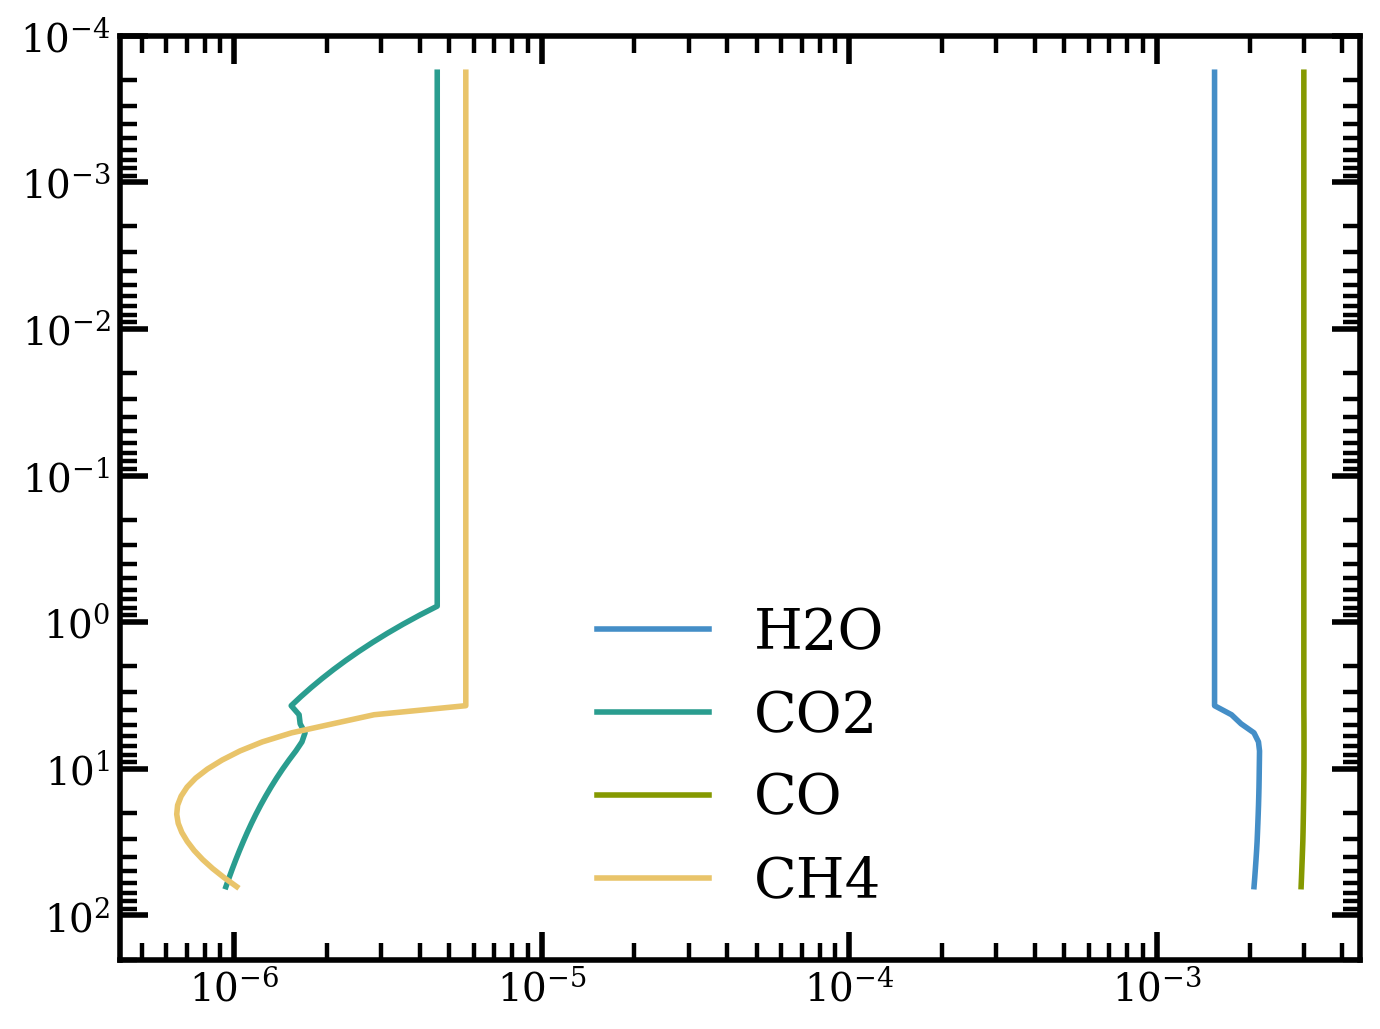

In [9]:
for i in ['H2O','CO2','CO','CH4']:
    plt.loglog(out['ptchem_df'][i], out['ptchem_df']['pressure'] ,label=i)
plt.legend()
plt.ylim([200,1e-4])

## Compare Diseq and Elf Owl Climate Profile 

For the case we chose with very low kzz, and solar M/H the disequilibrium profile and bobcat profiles are identical! 

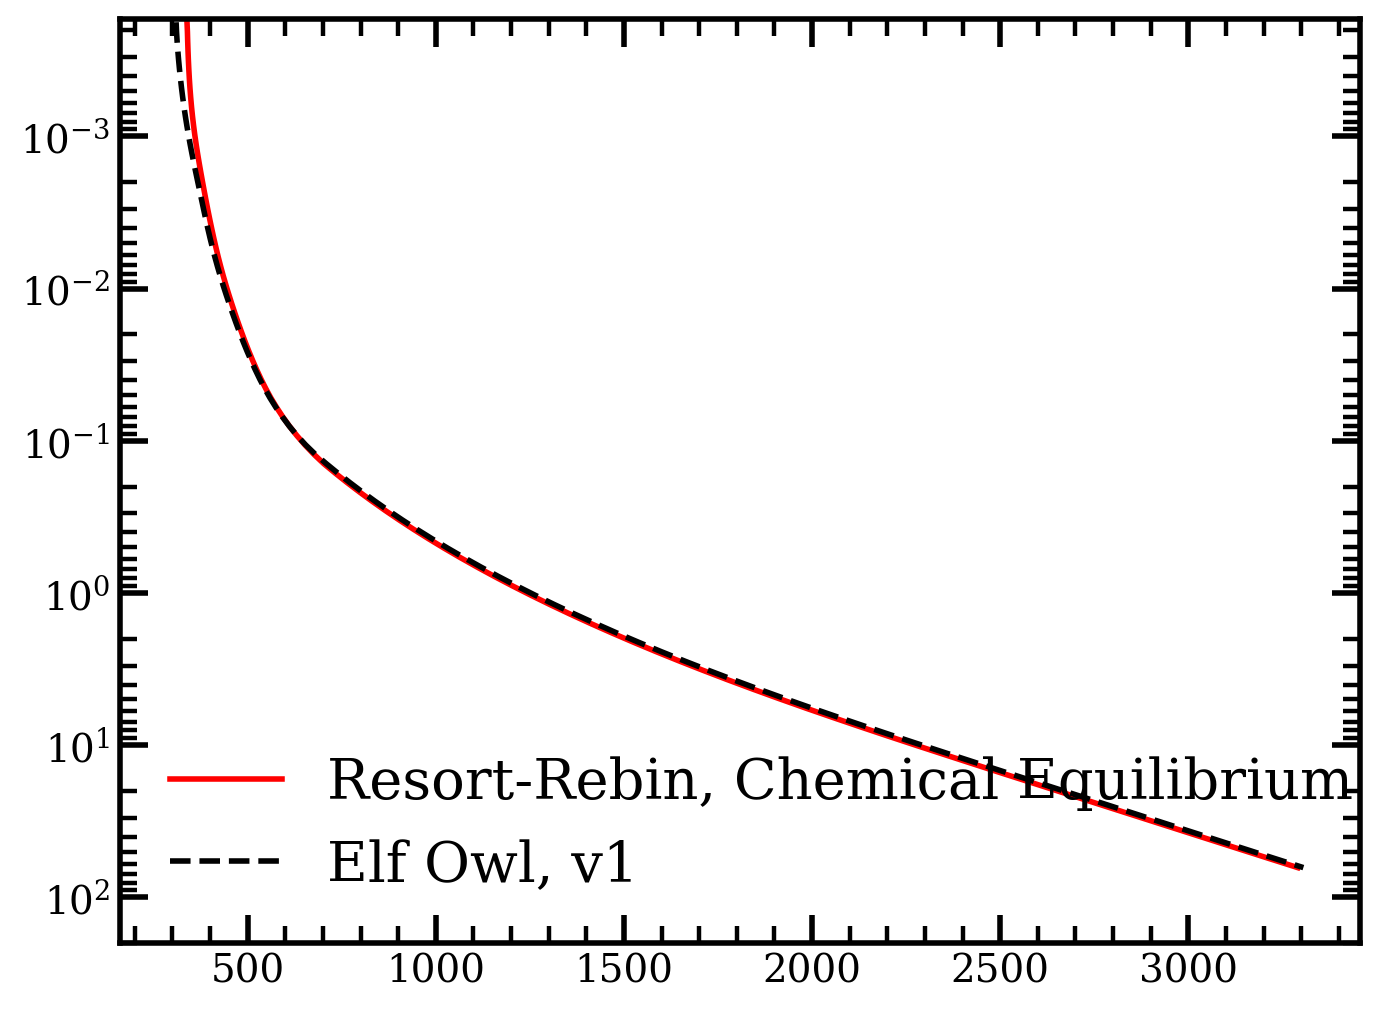

In [10]:
plt.ylim(200,1.7e-4)
plt.semilogy(out['temperature'],out['pressure'],"r", label='Resort-Rebin, Chemical Equilibrium')
plt.semilogy(temp_guess,pressure,color="k",linestyle="--", label='Elf Owl, v1')

plt.legend()